# Linear Regression

see: http://docs.pymc.io/notebooks/getting_started.html


$$Y \sim \mathcal{N}(\mu, \sigma^{2})$$

$$\mu = \alpha + \beta_1X_1 + \beta_2X_2$$

$$\alpha \sim \mathcal{N}(0, 100)$$

$$\beta_i \sim \mathcal{N}(0, 100)$$

$$\sigma \sim \lvert\mathcal{N}(0, 1)\rvert$$

## Import libraries

In [99]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
from scipy import optimize

import warnings
warnings.filterwarnings('ignore')

## Generating data

In [87]:
np.random.seed(123)

# true parameters
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha +  beta[0] * X1 + beta[1] * X2 + np.random.randn(size)*sigma

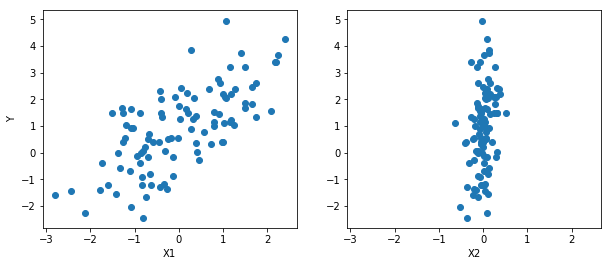

In [98]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

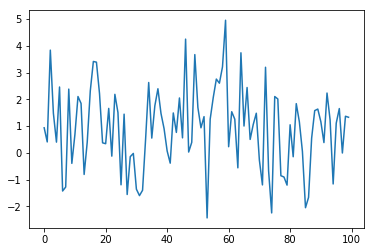

In [89]:
plt.plot(Y)

## Model specification

In [90]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    mu = alpha + beta[0] * X1 + beta[1] * X2
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

## Model fitting

Estimate MAP using default optimization algorithm (BFGS)

In [91]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 2362.08it/s]  


{'alpha': array(0.9066009314912588),
 'beta': array([ 0.94848596,  2.60711845]),
 'sigma': array(0.962988576897385),
 'sigma_log__': array(-0.03771372925085048)}

Estimate MAP using Powell's optimization algorithm

In [92]:
map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
map_estimate

logp = -149.47:   4%|▎         | 176/5000 [00:00<00:02, 2236.86it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.9090796395146067),
 'beta': array([ 0.9514399 ,  2.61452795]),
 'sigma': array(0.9656806239373007),
 'sigma_log__': array(-0.034922116477614396)}

TODO why?

```
It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.
```

## Sampling

Sample using default step method (NUTS)

In [93]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1015.84it/s]


In [94]:
trace['alpha'][-5:]

array([ 0.91876292,  0.87876942,  0.9565076 ,  0.94203071,  1.02499282])

Sample using slice method

In [95]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

logp = -149.47:   4%|▎         | 176/5000 [00:00<00:02, 2010.14it/s]


Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


100%|██████████| 5500/5500 [00:07<00:00, 706.89it/s]


## Posterior analysis

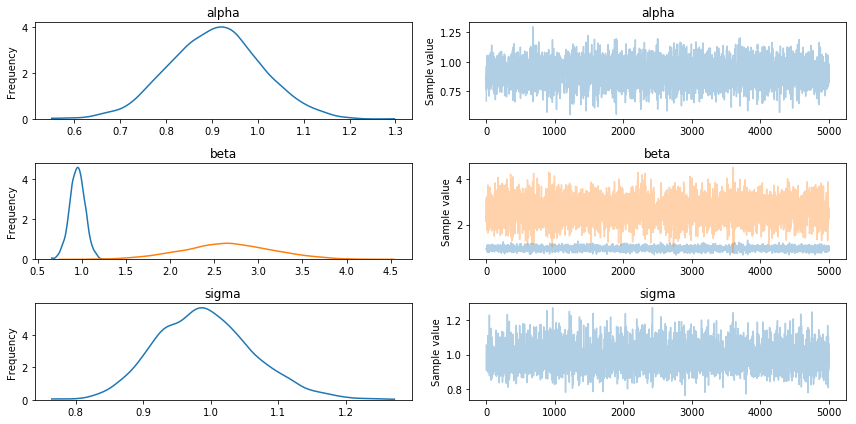

In [96]:
_ = pm.traceplot(trace)

In [97]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.906            0.100            0.001            [0.717, 1.109]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.709          0.839          0.907          0.971          1.102


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.086            0.001            [0.766, 1.110]
  2.655            0.514            0.008            [1.646, 3.670]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.775          0.891          0.948          1.005          1.120
  1.647          2.322          2.653   